In [1]:
import sys, pickle
print(sys.executable)
import sklearn.preprocessing as pre, scipy, numpy as np, matplotlib.pyplot as plt, glob, os, pyemma
import pandas as pd, seaborn as sns, argparse

/home/mikejones/anaconda3/bin/python


In [18]:
seq = 'AT-all'
meta_dict_path = f'{seq}_meta_dict_full'
#data_path = f'../../../dna_data/{seq}-fix_313K_112-150001-190.npy'
data_path = f'../../../dna_data/{seq}_306K_112-165001-190.npy'
n_traj, n_frames, skip = 100, 100001, 1

meta_dict = np.load(meta_dict_path, allow_pickle=True)
data = np.concatenate( np.load(data_path)[:n_traj, -n_frames::skip, :100])

print(data.shape)

(10000100, 100)


In [19]:
meta_data_dict = {}
for state, idxs in meta_dict.items():
    meta_data_dict[state] =  data[idxs]
    print(meta_data_dict[state].shape)   
    
pickle.dump(meta_data_dict, open(f'./{seq}_meta_data_dict_full', 'wb'))

(5169, 100)
(41077, 100)
(63713, 100)
(998909, 100)
(3948245, 100)
(4942987, 100)


In [ ]:
# find proximity of each 5' single shifted state to either the hybridized or dissociated states
def get_state_diff(k, state):
    
    return(np.min(np.abs(state - k)))

score_list = []
cnt = 0

for k in meta_dict[2]:
    
    hybrid = meta_dict[4]
    dehybrid = meta_dict[3]
    
    h_dist = get_state_diff(k, hybrid)
    d_dist = get_state_diff(k, dehybrid)
    
    if h_dist < 5:
        score = 2
    elif h_dist < 20:
        score = 1
    elif d_dist < 5:
        score = -2
    elif d_dist < 20:
        score = -1
    else:
        score = 0
        
    score_list.append(score)

    cnt += 1
    #if cnt > 1000:
        #break
        
print(len(score_list))
pickle.dump(score_list, open(f'./{seq}_5prime_score_list', 'wb'))

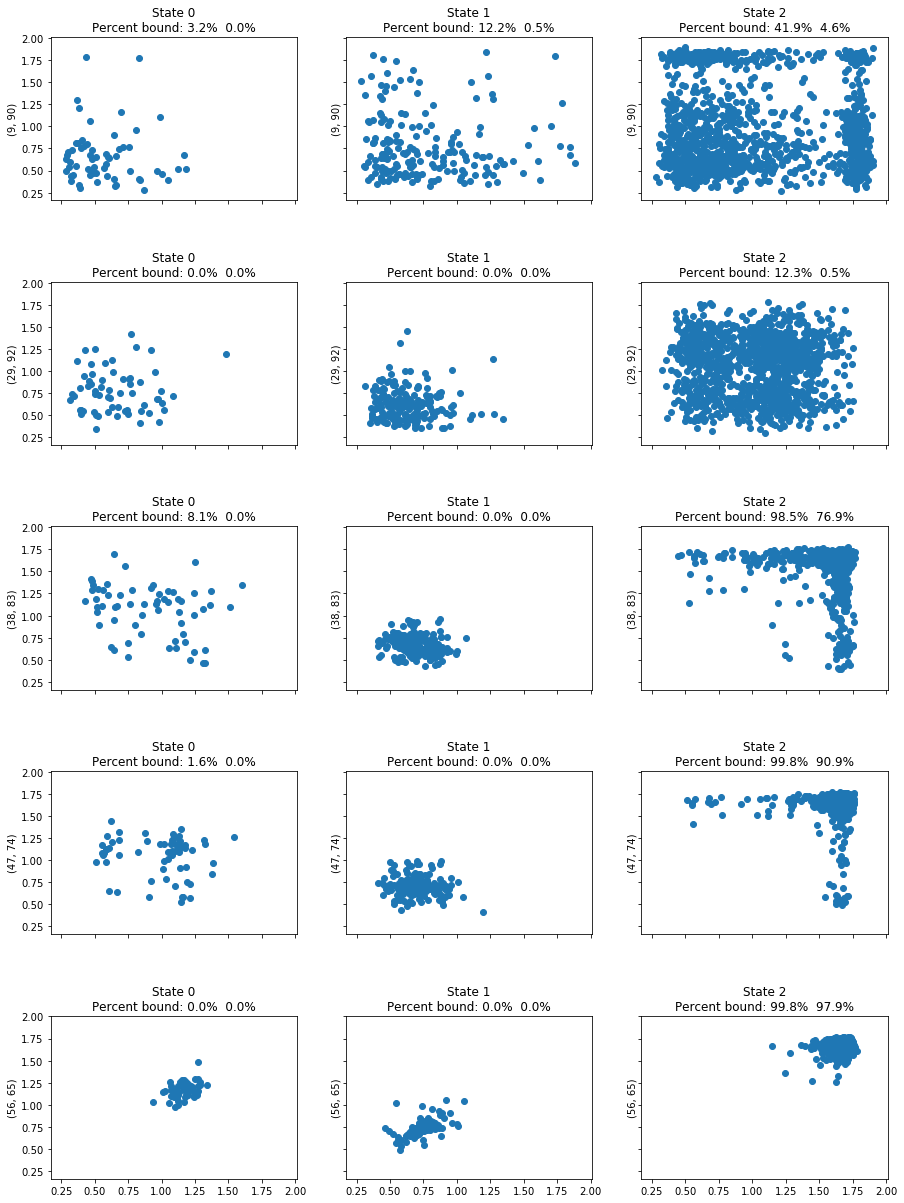

In [6]:
def find_ends_bound(frames):
    n_frames = len(frames)
    cutoff = 1.5
    n_one = 0
    n_both = 0
    for frame in frames:
        if frame[0] > cutoff or frame[1] > cutoff:
            n_one += 1
            
            if frame[0] > cutoff and frame[1] > cutoff:
                n_both += 1
    
    return [np.round(100*n_one/n_frames, 1), np.round(100*n_both/n_frames, 1)]

single_shift_5prime = [(9, 90), (29, 92), (38, 83), (47, 74), (56, 65)]
single_shift_3prime = [(9, 90), (7, 70), (16, 61), (25, 52), (34, 43)]
double_shift_5prime = [(9, 90), (49, 94), (58, 85), (67, 76)]
    
cv_list = single_shift_5prime

n_states = 3
fig, axes = plt.subplots(len(cv_list), n_states, sharex=True, sharey = True, figsize=(len(cv_list)*3, n_states*7))

for i in range(n_states):
    for j, cv in enumerate(cv_list):
    
        ax = axes[j, i]
        cv_frames = meta_data_dict[i][:, cv]
        p_bound = find_ends_bound(cv_frames)
        ax.scatter(cv_frames[:, 0], cv_frames[:, 1])
        ax.set_title(f'State {i}\nPercent bound: {p_bound[0]}%  {p_bound[1]}%')
        ax.set_ylabel(cv)
        
fig.subplots_adjust(hspace=0.5)
    